<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 드라이브 연동

#폰트
```
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
```

In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 참고
- https://eng.uber.com/forecasting-introduction/

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# ewm
# diff
# LGBM ???
# not global per month model


In [ ]:
# 모듈 임포트
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
import datetime
import seaborn as sns
sns.set()

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
#train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')
train = pd.read_csv("/content/train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train.DateTime)
date_time = pd.to_datetime(train.DateTime)
train['date'] = train.DateTime.dt.date
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24 * 60 * 60
week = (7)*day
month = (30.5)*day

#train['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
#train['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
#train['month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
#train['month cos'] = np.cos(timestamp_s * (2 * np.pi / month))

#left = train.iloc[:,:-4].groupby(train['date']).sum().reset_index()
#right = train.iloc[:,-4:].groupby(train['date']).mean().reset_index()
#train = pd.merge(left, right, on='date')
train = train.groupby(train['date']).sum().reset_index()
#train['linear time'] = [np.log(x) for x in range(1,len(train)+1)]

# 변수들 형태 확인

In [ ]:
import matplotlib.pyplot as plt

for key in  train.columns[1:]:
  plt.figure(figsize=(20,10))
  val = (train[key] - train[key].min()) / (train[key].max() - train[key].min())
  val.plot()
  plt.title(key, size=20)
  plt.xlabel('time', size=16)
  plt.ylabel('val', size=16)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
train

,date,사용자,세션,신규방문자,페이지뷰
0,2018-09-09,281,266,73,1826
1,2018-09-10,264,247,51,2092
2,2018-09-11,329,310,58,1998
3,2018-09-12,300,287,45,2595
4,2018-09-13,378,344,50,3845
...,...,...,...,...,...
787,2020-11-04,4516,4472,1196,112683
788,2020-11-05,4155,4037,1044,102901
789,2020-11-06,3663,3576,825,88015
790,2020-11-07,2472,2417,531,57386


# 데이터 전처리

In [ ]:
def make_data(df, windows=[30, 45, 60]):
  x, y = {},{}
  # scaling
  mini = df.iloc[:,1:].min()
  size = df.iloc[:,1:].max() - df.iloc[:,1:].min()
  new_train = df.copy()
  new_train.iloc[:,1:] = (df.iloc[:,1:] -  mini) / size

  for window_size in windows:
    # 30일 윈도우
    input_window = window_size
    # 문제가 7일 예측인듯???
    output_window = 7

    window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
    if window_size == 30:
      window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, df.shape[1]-1))

    for start in range(df.shape[0] - (input_window + output_window)):
        end = start + input_window    
        window_x[start,:, :] = new_train.iloc[start : end, 1: ].values
        if window_size == 30:
          window_y[start,:, :] = new_train.iloc[end   : end + output_window, 1: ].values
    
    x['win_' + str(window_size)] = window_x
    y = window_y

  return x, y, mini, size

In [ ]:
# fileloader
class DatasetWindows(Dataset):
  def __init__(self, df):
    x, y, mini, size = make_data(df)
    self.mini = mini
    self.size = size
    self.x_30 = torch.tensor(x['win_30'], dtype=torch.float32).cuda()
    self.x_45 = torch.tensor(x['win_45'], dtype=torch.float32).cuda()
    self.x_60 = torch.tensor(x['win_60'], dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    self.min_length = min(self.x_30.size()[0], self.x_45.size()[0], self.x_60.size()[0])

  def __len__(self):
    return 2
    
  def __getitem__(self, idx):
    idx  = np.random.randint(self.min_length-30, size=350) + 30
    # 끝일을 맞추어 주어야함...
    return self.x_30[idx,...], self.x_45[idx-15,...] ,self.x_60[idx-30,...] , self.y[idx,...]

In [ ]:
# fileloader
class DatasetWindows(Dataset):
  def __init__(self, df):
    x, y, mini, size = make_data(df)
    self.mini = mini
    self.size = size
    self.x_30 = torch.tensor(x['win_30'], dtype=torch.float32).cuda()
    self.x_45 = torch.tensor(x['win_45'], dtype=torch.float32).cuda()
    self.x_60 = torch.tensor(x['win_60'], dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    self.min_length = min(self.x_30.size()[0], self.x_45.size()[0], self.x_60.size()[0])

  def __len__(self):
    return 2
    
  def __getitem__(self, idx):
    idx  = np.random.randint(self.min_length-300, size=150) + 300
    # 끝일을 맞추어 주어야함...
    return self.x_30[idx,...], self.x_45[idx-15,...] ,self.x_60[idx-30,...] , self.y[idx,...]

# 모델

- CNN 추가??
- resudual connection 추가하기
- dialated LSTM???
- 다수 모델 mean 

In [ ]:
# baseline model
# with 3 branchs
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=30, window_size=30):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.lstm = nn.ModuleList([])
        for i in range(6):
          in_size = self.input_size
          if i>0:
            in_size = window_size
          self.lstm.append(
               nn.LSTM(input_size = in_size,
                            hidden_size = window_size,
                            num_layers=1,
                            batch_first=True))

        self.fc = nn.Sequential(nn.Linear(window_size, self.input_size))
    
    def forward(self, x):
        for i in range(6):
          x, _ = self.lstm[i](x)

        x = self.fc(x[:,-7:, :])

        return x.view(-1,7,self.input_size)

class ThreeLSTM(nn.Module):
  def __init__(self):
    super(ThreeLSTM, self).__init__()

    self.input_size=4
    
    self.lstm_30 = LSTM(input_size=self.input_size)
    self.lstm_45 = LSTM(input_size=self.input_size,window_size=45)
    self.lstm_60= LSTM(input_size=self.input_size,window_size=60)
    self.fc_along_time = nn.Sequential(nn.Linear(self.input_size*3, self.input_size))

  def forward(self, x):

    x_30, x_45, x_60 = x
    x_30 = (x_30.view(-1,30,self.input_size))
    x_45 = (x_45.view(-1,45,self.input_size))
    x_60 = (x_60.view(-1,60,self.input_size))
    
    # 700 7 4
    x_30 = self.lstm_30(x_30)
    # 700 7 4
    x_45 = self.lstm_45(x_45)
    # 700 7 4
    x_60 = self.lstm_60(x_60)

    #700 7 24 
    cated = torch.cat([x_30, x_45, x_60], dim=-1)
    #B 7 8 
    x = self.fc_along_time(cated)

    #350 7 4
    return x.view(-1,7,self.input_size)

In [ ]:
class Baseline(nn.Module):
    def __init__(self, input_size=4, hidden_size=30):
        super(Baseline, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_lstm = nn.LSTM(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True)

        self.fc = nn.Linear(hidden_size, hidden_size)
        self.time_fc = nn.Linear(hidden_size, 4)
    
    def forward(self, x_time):

        out_time, _ = self.lstm(x_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time, _ = self.hidden_lstm(out_time)
        
        
        out_time = self.time_fc(out_time[:,-7:, :])
        
        return out_time.view(-1,7,4)

In [ ]:
class ModelManager():
  def __init__(self, model, dataset, device='gpu', Baseline=False):
    super(ModelManager, self).__init__()
    self.model = model()
    if device == 'gpu':
      self.model =  model().cuda()
    self.Baseline = Baseline
    self.mini = dataset.mini
    self.size =dataset.size
    self.dataloader = DataLoader(dataset, batch_size=1,  num_workers=0, pin_memory=False)
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=True, val_set=None, train_set=None):
    # Train model
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    criterion = nn.MSELoss(size_average = True)
    model = self.model


    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, baseline=self.Baseline, get_loss=True)
      return val_loss

    for epoch in range(num_epochs):
      for data in self.dataloader:
          x_1, x_2, x_3, y = data
          if self.Baseline:
            train_pred = model(x_1.squeeze())
          else:
            train_pred = model([x_1, x_2, x_3])
          
          loss = criterion(train_pred, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      if epoch % 100 == 99:
        if log:
          if val_set.any().any():
            val_loss = get_val_loss()
            print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
          else: 
            print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")


  def get_AR_output(self, df_shape, df_train, baseline=False):
  
    result = df_shape.copy()
    
    model = self.model
    mini = self.mini
    size = self.size

    last_month = df_train.iloc[-30:,1:].values[np.newaxis,...]
    last_month = torch.tensor(last_month).float().cuda()

    last_long_month = df_train.iloc[-45:,1:].values[np.newaxis,...]
    last_long_month = torch.tensor(last_long_month).float().cuda()

    last_two_month = df_train.iloc[-60:,1:].values[np.newaxis,...]
    last_two_month = torch.tensor(last_two_month).float().cuda()

    result = result.iloc[:,:4]
    output_window = 7

    # AR 방식의 prediction
    model = model.eval()
    for start in range((len(result) - output_window)//7 + 2):
        start = start * 7
  
        if baseline:
          next_week = model(last_month)
        else:
          next_week = model([last_month, last_long_month, last_two_month])

        last_month = torch.cat([last_month[:,7:,:], next_week], axis = 1)
        last_long_month = torch.cat([last_long_month[:,7:,:], next_week], axis = 1)
        last_two_month = torch.cat([last_two_month[:,7:,:], next_week], axis = 1)

        pred_week = next_week.squeeze().cpu().detach().numpy()
        pred_week = pred_week * size.values + mini.values
        pred_week = pred_week.astype(int)
        
        
        if start/7 == (len(result) - output_window)//7 + 1:
            result.iloc[start :, :] = pred_week[-result.iloc[start :, :].shape[0]:,:4]
        else:
            result.iloc[start : start + output_window, :] = pred_week[:,:4]
    
    model = model.train()
    return result

  def make_val_plot(self, val_df, train_df, baseline=False, get_loss=False):
    # ploting하기...
    dataset = DatasetWindows(train_split)
    mini, size = dataset.mini, dataset.size
    pred = self.get_AR_output(val_df, train_df,  baseline=baseline)
    label = val_df
    
    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444
      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred.values)

    for key in pred.columns:
      plt.plot(figsize=(20,10))
      plt.plot(pred[key])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred.values)
    print('RMSE : ' + str(loss))


In [ ]:
# train val split
train_whole = train
train_split = train[:700]
val = train.iloc[700:, 1:]

dataset = DatasetWindows(train_split)
base = ModelManager(Baseline, dataset, Baseline=True)
base.fit(num_epochs=500, lr=1e-2, log=True, val_set=val, train_set=train_split)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 150, 7, 4])) that is different to the input size (torch.Size([150, 7, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100 Epochs train MSE: 0.00583,  100 Epochs val MSE: 4.03581
200 Epochs train MSE: 0.00197,  200 Epochs val MSE: 4.54246
300 Epochs train MSE: 0.00105,  300 Epochs val MSE: 4.15654
400 Epochs train MSE: 0.00047,  400 Epochs val MSE: 4.34000
500 Epochs train MSE: 0.00017,  500 Epochs val MSE: 3.94651


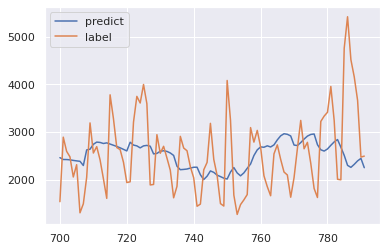

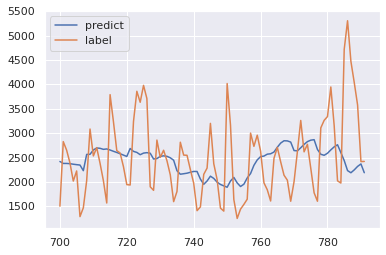

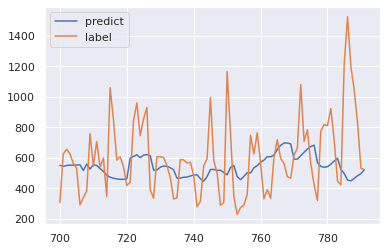

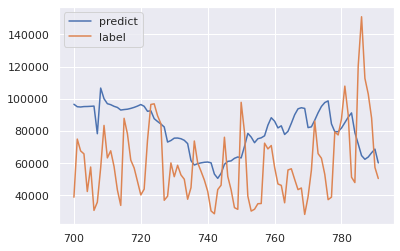

RMSE : 3.9465058551155865


In [ ]:
base.make_val_plot(val, train_split, baseline=True, get_loss=False)

In [ ]:
# train val split
train_whole = train
train_split = train[:700]
val = train.iloc[700:, 1:]

dataset = DatasetWindows(train_split)
mod = ModelManager(ThreeLSTM, dataset)
mod.fit(num_epochs=500, lr=1e-2, log=True, val_set=val, train_set=train_split)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 350, 7, 4])) that is different to the input size (torch.Size([350, 7, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100 Epochs train MSE: 0.00417,  100 Epochs val MSE: 4.08181
200 Epochs train MSE: 0.00322,  200 Epochs val MSE: 3.71505
300 Epochs train MSE: 0.00070,  300 Epochs val MSE: 4.30217
400 Epochs train MSE: 0.00032,  400 Epochs val MSE: 4.18735
500 Epochs train MSE: 0.00011,  500 Epochs val MSE: 3.95384


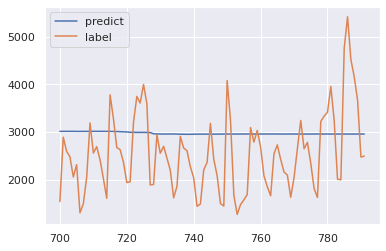

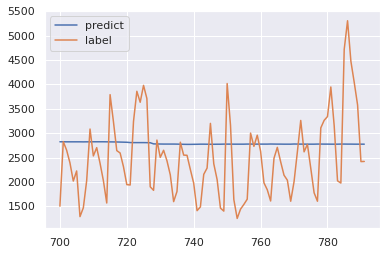

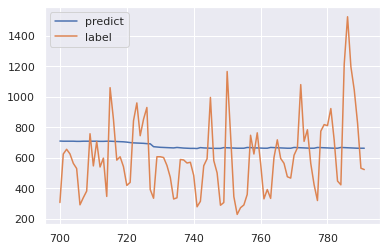

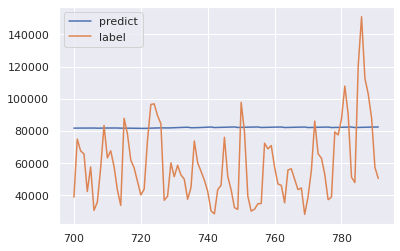

RMSE : 3.9538436356214666


In [ ]:
mod.make_val_plot(val, train_split, baseline=False, get_loss=False)

# 검증

In [ ]:
# 정규화 잘못됬을 수 있음...

In [ ]:
# baseline
# RMSE : 4.83002203285427
base.make_val_plot(val, train_split, baseline=True)

In [ ]:
# 3 window
# 4 layers
# 500 epoch
# RMSE : 4.49181163527573

In [ ]:
# 3 window
# 6 layers
# relu
# batchnormal
# residual
# 1000 epoch
# RMSE : 5.569989183993371
base.make_val_plot(val, train_split, baseline=True)

In [ ]:
class OutputManager():
  def __init__(self, train, model, ensemble=False):
    super(OutputManager,self).__init__()
    self.df = train
    self.model = model
    if ensemble:
      raise NotImplementedError

  
  def save_result(self, ensemble=False):

    # 마지막 한달으로 예측
    submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
    dataset_whole = DatasetWindows(self.df.iloc[:,:])

    for i in range(5):
      mod = ModelManager(self.model, dataset_whole)
      mod.fit(num_epochs=500, log=False)
      submission.iloc[:,1:] += mod.get_AR_output(submission.iloc[:,1:], self.df)

    submission.iloc[:,1:] = (submission.iloc[:,1:] / 5).astype(int)
    submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
    print(submission)
    print('saved result')

In [ ]:
OutputManager(train_whole, ThreeLSTM).save_result()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


      DateTime   사용자    세션  신규방문자   페이지뷰
0   2020-11-09  1189  1455    316  39701
1   2020-11-10  1204  1465    319  40103
2   2020-11-11  1271  1546    331  41099
3   2020-11-12  1353  1638    352  43503
4   2020-11-13  1313  1571    343  42901
..         ...   ...   ...    ...    ...
56  2021-01-04  1948  1891    472  60581
57  2021-01-05  1821  1748    415  56149
58  2021-01-06  1779  1712    404  54555
59  2021-01-07  1854  1791    434  57977
60  2021-01-08  1830  1770    414  60361

[61 rows x 5 columns]
saved result
